In [1]:
import glob

import pandas as pd
import numpy as np
from numpy import nan
import pygmo as pg

# -- visualization
import seaborn as sns
import matplotlib.pyplot as plt
from plotly import graph_objs as go
import plotly.express as px #https://plotly.com/python/getting-started/

sns.set(context='talk', style="whitegrid", font_scale=2, rc={'figure.figsize': (24, 13)})
# sns.set_style("whitegrid")
# sns.set_context("talk")
pd.set_option("display.max_columns", 75)

In [2]:
# --- Load data
def get_data_csv(path, **kwargs):
    df_group = [pd.read_csv(i_path, **kwargs) for i_path in glob.glob(path, recursive=True)]
    return pd.concat(df_group)

def get_data_pkl(path, **kwargs):
    df_group = [pd.read_pickle(i_path, **kwargs) for i_path in glob.glob(path, recursive=True)]
    return pd.concat(df_group)


# def make_nd_pop(pro, x, y):
#     nd_front = pg.fast_non_dominated_sorting(y)[0][0]
#     nd_x = np.array(x)[nd_front]
#     nd_y = np.array(y)[nd_front]
#     t_pop = pg.population(pro)
#     for i, p_vector in enumerate(nd_x):
#         t_pop.push_back(x=p_vector, f=nd_y[i])
#     return t_pop


def ndf_sort(x, y):
    ndf_idx = pg.fast_non_dominated_sorting(y)[0][0]
    return np.array(x)[ndf_idx].tolist(), np.array(y)[ndf_idx].tolist()

___

## Open data

### [GBR,GBR], [MLPR, MLPR]

- paper_solo_on_wfg_*.*.csv - final results
- \*paper_solo_loop\* - results per iteration

In [3]:
%%time
loop_columns = ['iteration', 'problem', 'objectives', 'feature_dim', 'i_fevals', 'pop_ndf_x', 'pop_ndf_y', 'model name', 'solver_id']

gbr_gbr = get_data_pkl('solo/gbr_15_04/WFG*_10_paper_solo_loop.*.pkl').query("problem=='WFG1'")[loop_columns]
mlpr_mlpr = get_data_pkl('solo/mlpr_15_04/WFG*_10_paper_solo_loop.*.pkl').query("problem=='WFG1'")[loop_columns]

CPU times: user 2.25 s, sys: 217 ms, total: 2.46 s
Wall time: 2.49 s


____

### [SVR, SVR], [GPR, GPR], [GPR]

/results_08_05

In [4]:
%%time

# all data
loop_columns = ['iteration', 'problem', 'objectives', 'feature_dim', 'i_fevals', 'pop_ndf_x', 'pop_ndf_y', 'model name', 'solver_id']

# df = get_data_pkl('solo/solo_model_sobol_100_wfg1/WFG1*_paper_solo_loop.*.pkl')[loop_columns]
solo_df = get_data_pkl('solo/v1_solo/WFG12_10_paper_tutor_loop.*.pkl').rename({'tutor_id': 'solver_id'}, axis='columns')[loop_columns]

CPU times: user 953 ms, sys: 23.6 ms, total: 977 ms
Wall time: 989 ms


In [5]:
# Get `solver_id`
model_id_df = solo_df[['model name', 'solver_id']]
model_id_df['model name'] = model_id_df['model name'].astype(str)
svr_solvers = model_id_df[model_id_df['model name']=="['svr', 'svr']"]['solver_id']
solo_gpr_solvers = model_id_df[model_id_df['model name']=='gaussianprocessregressor']['solver_id'] # multi-obj
gpr_solvers = model_id_df[model_id_df['model name']=="['gaussianprocessregressor', 'gaussianprocessregressor']"]['solver_id'] # duplicates

# [SVR, SVR]
svr_svr = solo_df[solo_df['solver_id'].isin(svr_solvers)]

# [GPR, GPR]
gpr_gpr = solo_df[solo_df['solver_id'].isin(gpr_solvers)]

# [GPR]
solo_gpr = solo_df[solo_df['solver_id'].isin(solo_gpr_solvers)]

<ipython-input-5-80cbb3c60714>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_id_df['model name'] = model_id_df['model name'].astype(str)


____

### Tutor

- basic tutor

In [6]:
%%time

loop_columns = ['iteration', 'problem', 'objectives', 'feature_dim', 'i_fevals', 'pop_ndf_x', 'pop_ndf_y', 'model name', 'tutor_id']
tutor_dynamic = get_data_pkl('tutorm/default_tutor/*/WFG1*_10_default_tutor_loop.*.pkl')[loop_columns] # init 0,  score >0.65/0.6, stack

CPU times: user 87.1 ms, sys: 0 ns, total: 87.1 ms
Wall time: 90.5 ms


In [7]:
tutor_1_wfg1 = get_data_csv('tutorm/paper/bench_1/WFG12_10_paper_tutor_loop.*.csv')[loop_columns].drop_duplicates() # init 100,  score >-1000, ndf
tutor_2_wfg1 = get_data_csv('tutorm/paper/bench_2/WFG12_10_paper_tutor_loop.*.csv')[loop_columns].drop_duplicates() # init 100,  score >-1000, stack
tutor_3_wfg1 = get_data_csv('tutorm/paper/bench_3/WFG12_10_paper_tutor_loop.*.csv')[loop_columns].drop_duplicates() # init 100,  score >0.65/0.6, stack

### [RF] 
- Hypermapper

In [8]:
mapper = get_data_csv('moo_paper_misc_15_04/data (copy)/hypermapper/concat/WFG1_22_5000.csv')
mapper['hypervolume'] = None
mapper

i_fevals  Timestamp        x2            x1        f2        f1  \
0            1          4  0.361357  7.363853e-01  1.000329  2.933185   
1            2          4  3.692340  2.086609e-01  1.048147  2.857833   
2            3          4  3.973146  3.507300e-01  1.024604  2.892274   
3            4          4  2.997057  7.222882e-01  0.996866  2.928245   
4            5          4  3.341382  9.127031e-01  0.997912  2.946557   
...        ...        ...       ...           ...       ...       ...   
4995       996    4785217  2.770070  6.909693e-08  2.115456  2.106409   
4996       997    4791252  1.400002  1.707539e+00  0.755395  2.745457   
4997       998    4797356  1.400324  2.000000e+00  0.836509  2.836509   
4998       999    4803496  1.399995  5.889957e-01  0.786656  2.701787   
4999      1000    4809398  2.071969  1.380514e-06  1.835893  2.217833   

      p_distance hypervolume  ndf_size  i_time  init_size problem group_id  
0            NaN        None         0       0        100    WFG1  ermappe  
1            NaN        None         0       0        100    WFG1  ermappe  
2            NaN        None         3       0        100    WFG1  ermappe  
3            NaN        None         3       0        100    WFG1  ermappe  
4            NaN        None         3       0        100    WFG1  ermappe  
...          ...         ...       ...     ...        ...     ...      ...  
4995         NaN        None       296    5884        100    WFG1  ermappe  
4996         NaN        None       297    6035        100    WFG1  ermappe  
4997         NaN        None       297    6104        100    WFG1  ermappe  
4998         NaN        None       298    6140        100    WFG1  ermappe  
4999         NaN        None       298    5902        100    WFG1  ermappe  

[5000 rows x 13 columns]

### NSGA-2
- baseline (evaluation budget 50 000)
- competitor approach (evaluation budget 1000)

In [9]:
# nsga2 = get_data_csv('moea/concat/nsga2_on_WFG4_22_750k.csv').query('i_gen<=500').rename({'x_0': 'x_1', 'x_1': 'x_2', 'f_0': 'f_1', 'f_1': 'f_2'}, axis='columns')


col_names = {'x_0': 'x_1', 'x_1': 'x_2', 'f_0': 'f_1', 'f_1': 'f_2'}

# --- NSGA2
nsga2_df = pd.read_csv('moea/concat/nsga2_on_WFG1_22_750k.csv').query('i_fevals<=1000')
nsga2_df.rename(columns={"f_0": "f1", "f_1": "f2"}, inplace=True)
# baseline for reference point
baseline_df = pd.read_csv('moea/concat/nsga2_on_WFG1_22_750k.csv').query('i_fevals==50000')
baseline_df.rename(columns={"f_0": "f1", "f_1": "f2"}, inplace=True)
# # --- NSGA2 50k
# nsga2_50k_df = pd.read_csv('moea/concat/nsga2_on_WFG1_22_750k.csv')
# nsga2_50k_df.rename(columns={"f_0": "f1", "f_1": "f2"}, inplace=True)
# selection = nsga2_50k_df['group_id'].unique()[0]
# nsga2_50k_df = nsga2_50k_df[nsga2_50k_df['group_id']==selection]

____

## Reference point


In [10]:
tutorm_objectives = np.concatenate([np.concatenate([np.reshape(np.matrix(f), (-1, 2)) for f in df['pop_ndf_y'].values]) for df in [solo_gpr, gbr_gbr, mlpr_mlpr, svr_svr, gpr_gpr, tutor_1_wfg1, tutor_2_wfg1, tutor_3_wfg1, tutor_dynamic]])
all_objectives = np.concatenate([tutorm_objectives, nsga2_df[['f1', 'f2']].values, mapper[['f1', 'f2']].values, baseline_df[['f1', 'f2']].values])
ref_point = np.amax(all_objectives, axis=0).tolist()[0]
ref_point

[2.999875536620745, 4.837506883937272]

## Update hypervolume

In [11]:
# hypermapper and nsga2
def upd_hypervolume_nsga2(focus_df, ref_point):    
    df_copy = focus_df.copy()
    obj = df_copy[['f1', 'f2']].values
    hypervolume = []
    for i in range(len(df_copy)):
        if i < 2:
            hypervolume.append(0)
        else:
            hypervolume.append(pg.hypervolume(obj[:i+1]
                                         ).compute(ref_point))
    df_copy['hypervolume'] = hypervolume
    return df_copy

def row_upd_hypervolume(row, ref_point):
    hypervolume = pg.hypervolume(np.reshape(np.matrix(row['pop_ndf_y']), (-1, 2))).compute(ref_point)
    row['hypervolume'] = hypervolume
    return row

In [12]:
%%time

# --- hypermapper
mapper = pd.concat([upd_hypervolume_nsga2(mapper[:1000], ref_point),
upd_hypervolume_nsga2(mapper[1000:2000], ref_point),
upd_hypervolume_nsga2(mapper[2000:3000], ref_point),
upd_hypervolume_nsga2(mapper[3000:4000], ref_point),
upd_hypervolume_nsga2(mapper[4000:5000], ref_point)])

mapper.loc[0:1000, 'solver_id'] = 1 
mapper.loc[1000:2000, 'solver_id'] = 2
mapper.loc[2000:3000, 'solver_id'] = 3
mapper.loc[3000:4000, 'solver_id'] = 4
mapper.loc[4000:5000, 'solver_id'] = 5

# --- NSGA2
nsga2_df = upd_hypervolume_nsga2(nsga2_df, ref_point)

# --- baseline from NSGA2 50k
baseline_df = upd_hypervolume_nsga2(baseline_df, ref_point)

CPU times: user 5.06 s, sys: 5.04 ms, total: 5.07 s
Wall time: 5.07 s


In [13]:
gbr_gbr = gbr_gbr.apply(lambda row: row_upd_hypervolume(row, ref_point), axis=1) 
mlpr_mlpr = mlpr_mlpr.apply(lambda row: row_upd_hypervolume(row, ref_point), axis=1)  
svr_svr = svr_svr.apply(lambda row: row_upd_hypervolume(row, ref_point), axis=1)  
gpr_gpr = gpr_gpr.apply(lambda row: row_upd_hypervolume(row, ref_point), axis=1)  
solo_gpr = solo_gpr.apply(lambda row: row_upd_hypervolume(row, ref_point), axis=1)  
tutor_1_wfg1 = tutor_1_wfg1.apply(lambda row: row_upd_hypervolume(row, ref_point), axis=1)  
tutor_2_wfg1 = tutor_2_wfg1.apply(lambda row: row_upd_hypervolume(row, ref_point), axis=1)  
tutor_3_wfg1 = tutor_3_wfg1.apply(lambda row: row_upd_hypervolume(row, ref_point), axis=1) 
tutor_dynamic = tutor_dynamic.apply(lambda row: row_upd_hypervolume(row, ref_point), axis=1)

#### Relative hypervolume

In [14]:
# ---- Max
max_hv = baseline_df.query('i_fevals==50000').hypervolume.unique().max()

# ---- Min
udp = pg.wfg(prob_id=1, dim_dvs=2, dim_obj=2, dim_k=1)  # == WFG
pro = pg.problem(udp)
pop = pg.population(pro, size=10, seed=42)
# min_hv = pg.hypervolume(pop).compute(ref_point)
min_hv = 0

In [15]:
gbr_gbr['approach:'] = "[GBR, GBR]"
mlpr_mlpr['approach:'] = "[MLPR, MLPR]"
svr_svr['approach:'] = "[SVR, SVR]"
gpr_gpr['approach:'] = "[GPR, GPR]"
solo_gpr['approach:'] = "GPR"
tutor_1_wfg1['approach:'] = "TutorM: basic"
tutor_2_wfg1['approach:'] = "TutorM: portfolio"
tutor_3_wfg1['approach:'] = "TutorM: dynamic+100"
tutor_dynamic['approach:'] = "TutorM: dynamic"

baseline_df['approach:'] = "Baseline"
mapper['approach:'] = "Hypermapper 2.0"
nsga2_df['approach:'] = "NSGA-II"


In [16]:
for df in [gbr_gbr, mlpr_mlpr, svr_svr, solo_gpr, gpr_gpr, tutor_1_wfg1, tutor_2_wfg1, tutor_3_wfg1, baseline_df, mapper, nsga2_df, tutor_dynamic]:
    df['hypervolume_%'] = ((df['hypervolume']-min_hv)/(max_hv-min_hv))*100

## Duplicated scalarized and compositional models

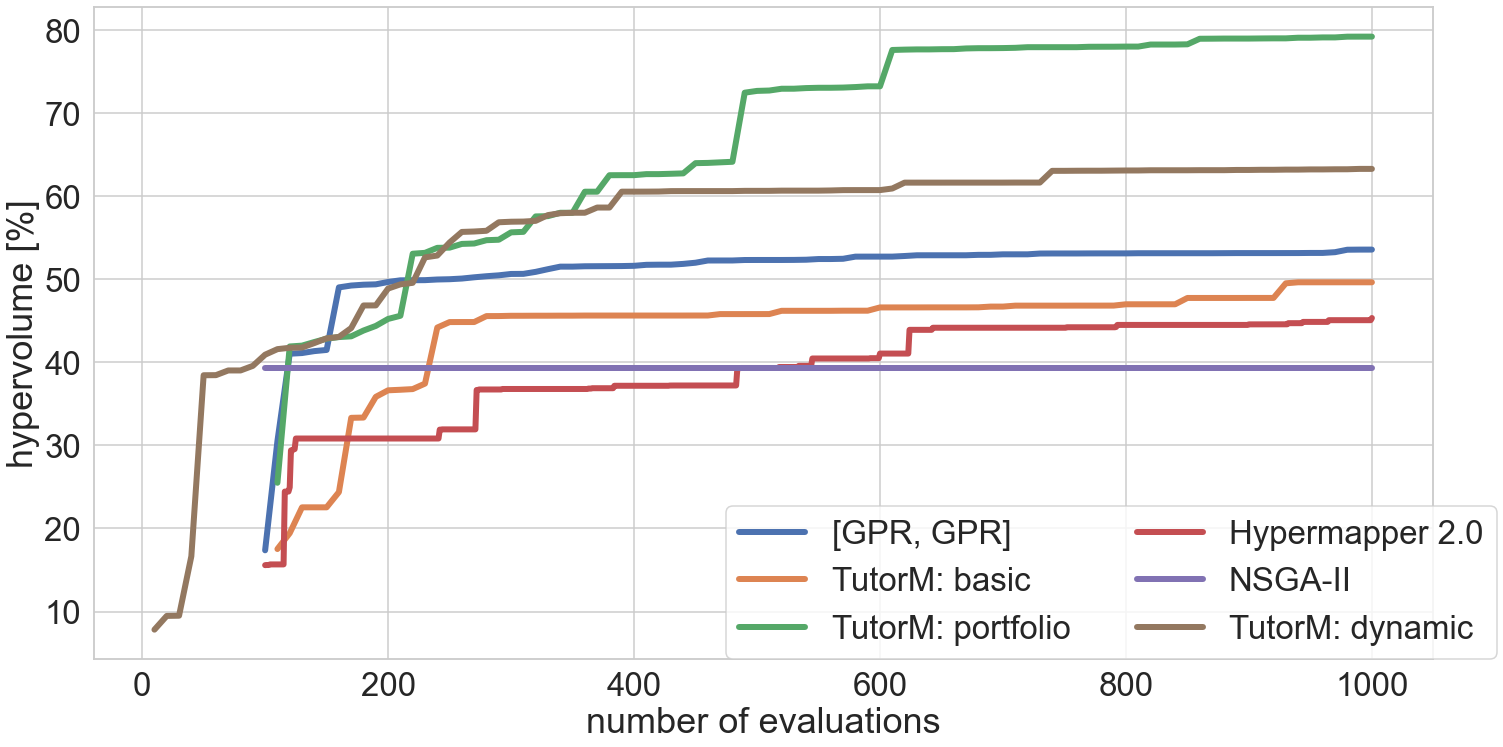

In [17]:
def basic_plot():
    sns.set_context("talk",
                    font_scale=2,
                    rc={"lines.linewidth": 6,
                        'lines.markersize': 18}) 
    sns.set_style("whitegrid")
    EXP_ORDER = 2

    plt.figure(figsize=(24, 12))
    p = sns.lineplot(x="i_fevals", y="hypervolume_%", 
                     markers=True,
                     hue="approach:",
                     palette="deep", 
                     ci=True,
                     data=pd.concat([list(t.groupby('solver_id'))[EXP_ORDER][1] for t in [gpr_gpr, 
                                                                                         tutor_1_wfg1.rename({'tutor_id': 'solver_id'}, axis='columns'), 
                                                                                         tutor_2_wfg1.rename({'tutor_id': 'solver_id'}, axis='columns'), 
                                                                                         mapper.query('i_fevals>=100'), 
                                                                                         nsga2_df.rename({'group_id': 'solver_id'}, axis='columns'), 
                                                                                         tutor_dynamic.rename({'tutor_id': 'solver_id'}, axis='columns')]]))
    p.set(xlabel="number of evaluations")
    p.set(ylabel="hypervolume [%]")
    plt.legend(loc='upper center', bbox_to_anchor=(0.76, 0.26),  ncol=2)
    # plt.savefig('basic.pdf', bbox_inches = 'tight')
    
basic_plot()

## Pareto front for one experiment

[(0.2980392156862745, 0.4470588235294118, 0.6901960784313725), (0.8666666666666667, 0.5176470588235295, 0.3215686274509804), (0.3333333333333333, 0.6588235294117647, 0.40784313725490196), (0.7686274509803922, 0.3058823529411765, 0.3215686274509804), (0.5058823529411764, 0.4470588235294118, 0.7019607843137254), (0.5764705882352941, 0.47058823529411764, 0.3764705882352941), (0.8549019607843137, 0.5450980392156862, 0.7647058823529411), (0.5490196078431373, 0.5490196078431373, 0.5490196078431373), (0.8, 0.7254901960784313, 0.4549019607843137), (0.39215686274509803, 0.7098039215686275, 0.803921568627451), (0.7215686274509804, 0.5254901960784314, 0.043137254901960784)]


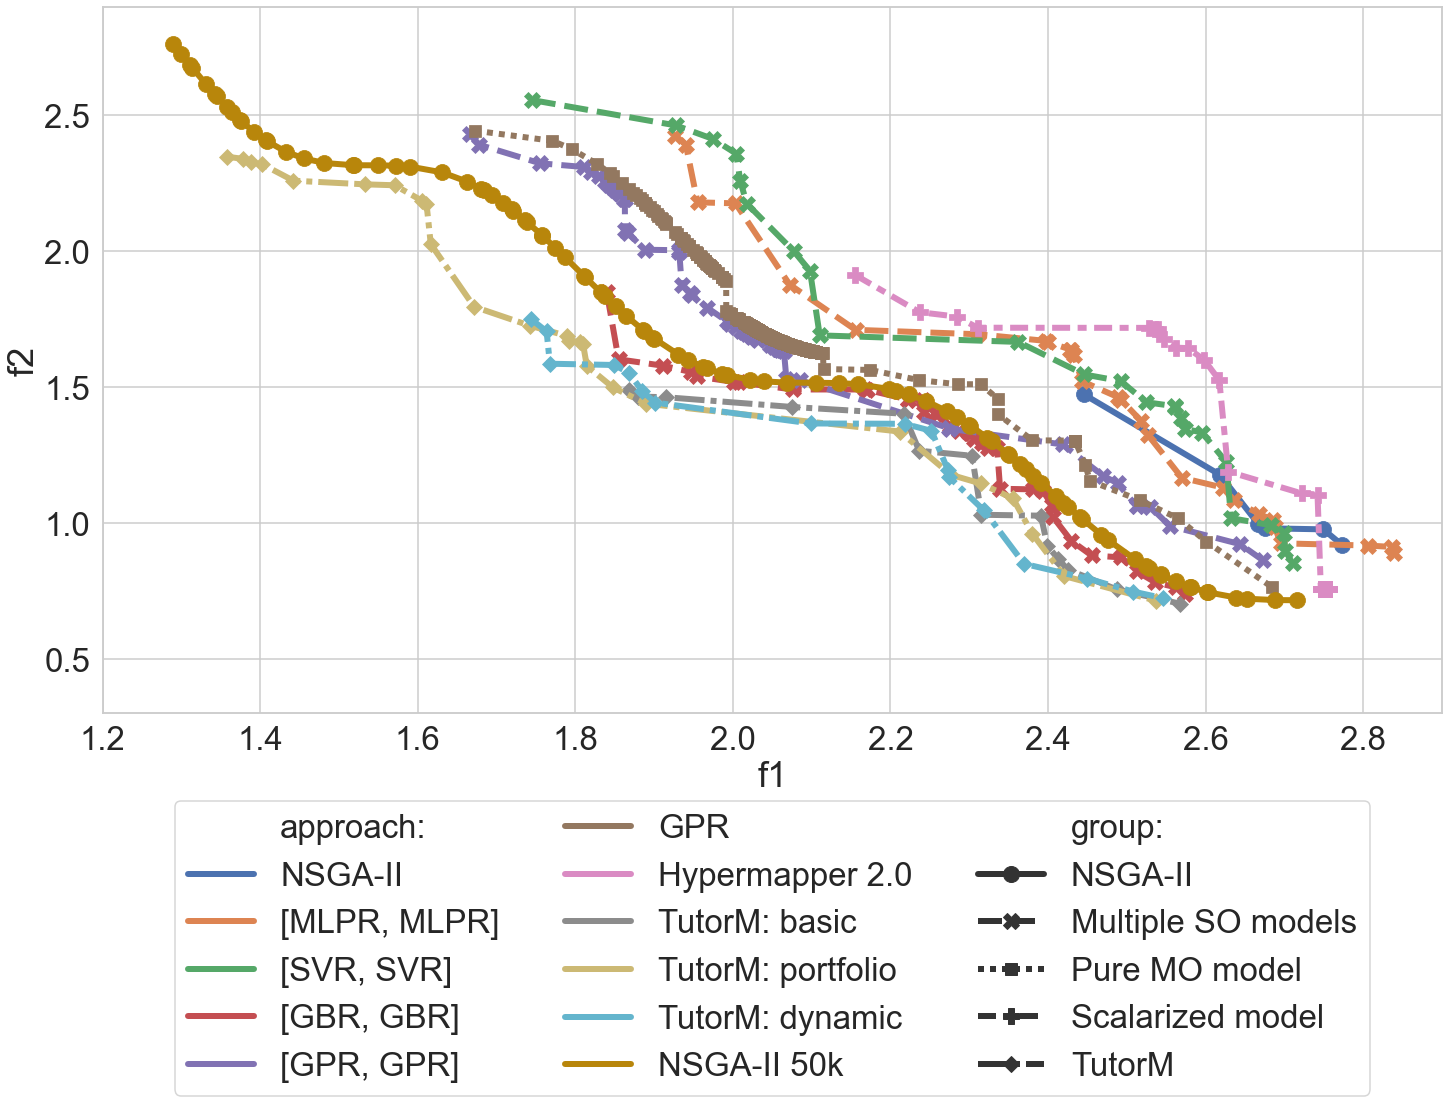

In [18]:
def pareto_trial_plot():
    sns.set_context("talk",
                    font_scale=2,
                    rc={"lines.linewidth": 6,
                       'lines.markersize': 16}) 
    sns.set_style("whitegrid")
    
    EXP_ORDER = None  # 0-4

    summ = []

    # --- NSGA2
    all_points = nsga2_df.groupby('i_fevals').apply(lambda focus_df: focus_df.iloc[2])
    index_ndf, dl, dc, ndr = pg.fast_non_dominated_sorting(all_points[['f1','f2']].values)
    temp_nsga2 = all_points.iloc[index_ndf[0]][['f1', 'f2', 'approach:']]
    
    temp_nsga2['group:'] = 'NSGA-II'

    summ.append(temp_nsga2)

    
    # --- Duplicated models
    for temp_df in [mlpr_mlpr, svr_svr, gbr_gbr, gpr_gpr]:
        i_result = temp_df.query('i_fevals==1000').iloc[4]
        temp_static = pd.DataFrame(i_result.pop_ndf_y, columns=['f1', 'f2'])
        temp_static['approach:'] = i_result['approach:']
        temp_static['group:'] = 'Multiple SO models'
        summ.append(temp_static)

    # --- GPR
    gpr_result = solo_gpr.query('i_fevals==1000').iloc[0]
    temp_static = pd.DataFrame(gpr_result.pop_ndf_y, columns=['f1', 'f2'])
    temp_static['approach:'] = gpr_result['approach:']
    temp_static['group:'] = 'Pure MO model'
    summ.append(temp_static)
    
    # --- Hypermapper

    all_points = mapper.groupby('i_fevals').apply(lambda focus_df: focus_df.iloc[1])
    index_ndf, dl, dc, ndr = pg.fast_non_dominated_sorting(all_points[['f1','f2']].values)
    temp_mapper = all_points.iloc[index_ndf[0]][['f1','f2','approach:']]
    temp_mapper['group:'] = 'Scalarized model'
    temp_mapper['approach:'] = "Hypermapper 2.0"

    summ.append(temp_mapper)


    # --- TutorM
    for temp_df in [tutor_1_wfg1, tutor_2_wfg1, tutor_dynamic]:
        i_result = temp_df.query('i_fevals==1000').iloc[0]

        temp_tutor = pd.DataFrame(np.reshape(np.matrix(i_result['pop_ndf_y']), (-1, 2)), columns=['f1', 'f2'])
        temp_tutor['approach:'] = i_result['approach:']
        temp_tutor['group:'] = 'TutorM'
        summ.append(temp_tutor)

    # --- [Baseline] NSGA2 50k
    temp_base = list(baseline_df.groupby('group_id'))[1][1]
    temp_base = temp_base[['f1', 'f2']]
    temp_base['group:'] = 'NSGA-II'
    temp_base['approach:'] = 'NSGA-II 50k'
    summ.append(temp_base)
    
    custom_palette = list(sns.color_palette("deep", 10))
    custom_palette.append((0.7215686274509804, 0.5254901960784314, 0.043137254901960784))
    print(custom_palette)
    sns.lineplot(data=pd.concat(summ), 
                 x='f1', y='f2', 
                 markers=True, 
                 ci=95,
                 markeredgecolor=None,
                 palette=custom_palette, 
                 style="group:", 
                 hue='approach:')
    
    plt.xlim(1.2, 2.9)
    plt.ylim(0.3, 2.9)
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3)
    plt.savefig('pareto.v1.pdf', bbox_inches = 'tight')
    
pareto_trial_plot()

## Generalized Pareto front
- Generic representation of the final Pareto front for each approach after 5 experiments.

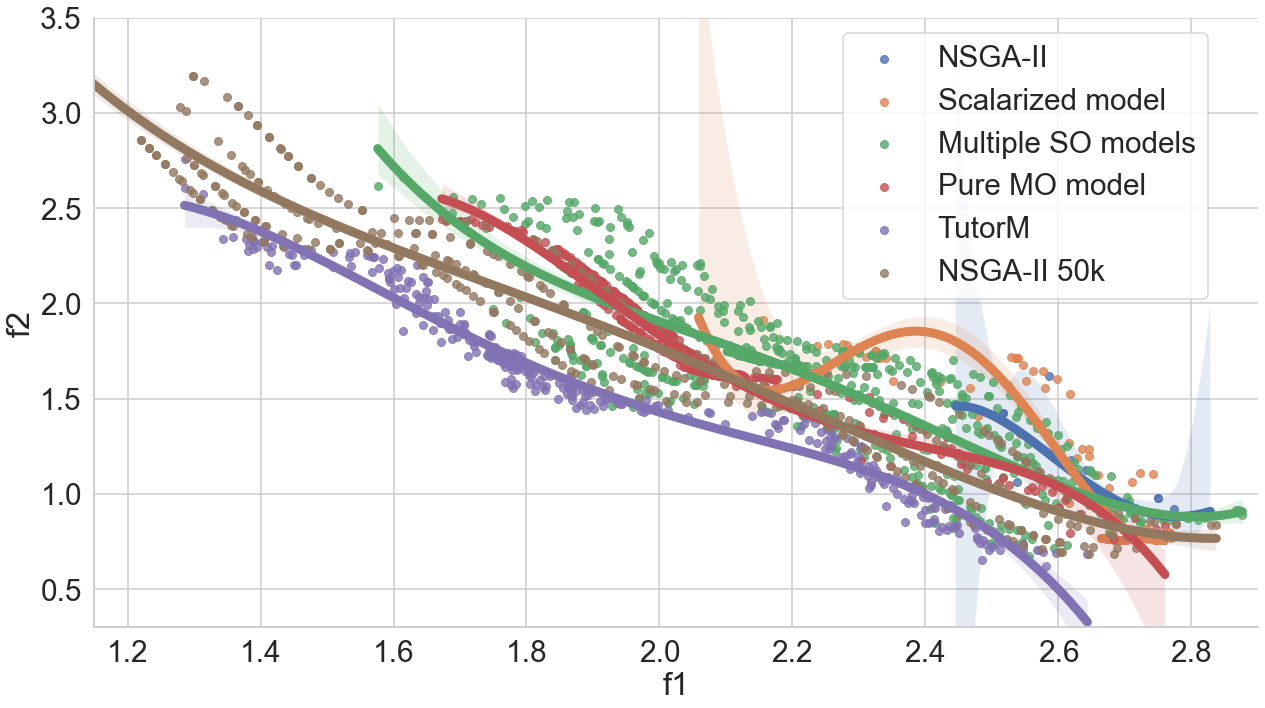

In [19]:
def pareto_ext_plot():
    sns.set_context("talk",
                    font_scale=1.8,
                    rc={"lines.linewidth": 6,
                       'lines.markersize': 8}) 
    sns.set_style("whitegrid")
    summ = []

    #                                                                                --- NSGA2
    for EXP_ORDER in range(4):
        all_points = nsga2_df.groupby('i_fevals').apply(lambda focus_df: focus_df.iloc[EXP_ORDER])
        index_ndf, dl, dc, ndr = pg.fast_non_dominated_sorting(all_points[['f1','f2']].values)
        temp_nsga2 = all_points.iloc[index_ndf[0]][['f1', 'f2', 'approach:']]
        temp_nsga2['group:'] = 'NSGA-II'

        summ.append(temp_nsga2)

    #                                                                               --- Hypermapper
    for EXP_ORDER in range(4):
        all_points = mapper.groupby('i_fevals').apply(lambda focus_df: focus_df.iloc[EXP_ORDER])
        index_ndf, dl, dc, ndr = pg.fast_non_dominated_sorting(all_points[['f1','f2']].values)
        temp_mapper = all_points.iloc[index_ndf[0]][['f1','f2','approach:']]
        temp_mapper['group:'] = 'Scalarized model'
        temp_mapper['approach:'] = "Hypermapper 2.0"
        summ.append(temp_mapper)

    #                                                                              --- Duplicated models
    for EXP_ORDER in range(4):
        for temp_df in [mlpr_mlpr, svr_svr, gbr_gbr, gpr_gpr]:
            i_result = temp_df.query('i_fevals==1000').iloc[EXP_ORDER]
            temp_static = pd.DataFrame(i_result.pop_ndf_y, columns=['f1', 'f2'])
            temp_static['approach:'] = i_result['approach:']
            temp_static['group:'] = 'Multiple SO models'
            summ.append(temp_static)
            
    #                                                                              --- Solo models
    for EXP_ORDER in range(4):
        i_result = solo_gpr.query('i_fevals==1000').iloc[EXP_ORDER]
        temp_static = pd.DataFrame(i_result.pop_ndf_y, columns=['f1', 'f2'])
        temp_static['approach:'] = i_result['approach:']
        temp_static['group:'] = 'Pure MO model'
        summ.append(temp_static)

    #                                                                              --- TutorM
    for EXP_ORDER in range(4):
        for temp_df in [tutor_1_wfg1, tutor_2_wfg1, tutor_dynamic]:
            i_result = temp_df.query('i_fevals==1000').iloc[EXP_ORDER]

            temp_tutor = pd.DataFrame(np.reshape(np.matrix(i_result['pop_ndf_y']), (-1, 2)), columns=['f1', 'f2'])
            temp_tutor['approach:'] = i_result['approach:']
            temp_tutor['group:'] = 'TutorM'
            summ.append(temp_tutor)

    #                                                                              --- [Baseline] NSGA2 50k
    for EXP_ORDER in range(4):
        temp_base = list(baseline_df.groupby('group_id'))[EXP_ORDER][1]
        temp_base = temp_base[['f1', 'f2']]
        temp_base['group:'] = 'NSGA-II 50k'
        temp_base['approach:'] = 'NSGA-II 50k'
        summ.append(temp_base)
        
    sns.lmplot(data=pd.concat(summ), 
                 x='f1', y='f2', 
                 ci=90,
                 order=4,
#                  robust=True,
#                  logx=True,
                 legend=False,
                 palette="deep", 
#                  n_boot=30,
#                  lowess=True,
                 hue='group:',
                 aspect=16/9,
                 height=10)
    plt.xlim(1.15, 2.9)
    plt.ylim(0.3, 3.5)
    plt.legend(loc='upper center', bbox_to_anchor=(0.8, 1))
    plt.savefig('pareto.v2.pdf', bbox_inches = 'tight')
    
pareto_ext_plot()

___

## Correspondence between surrogate model and iteration
- Tutorm for one experiment

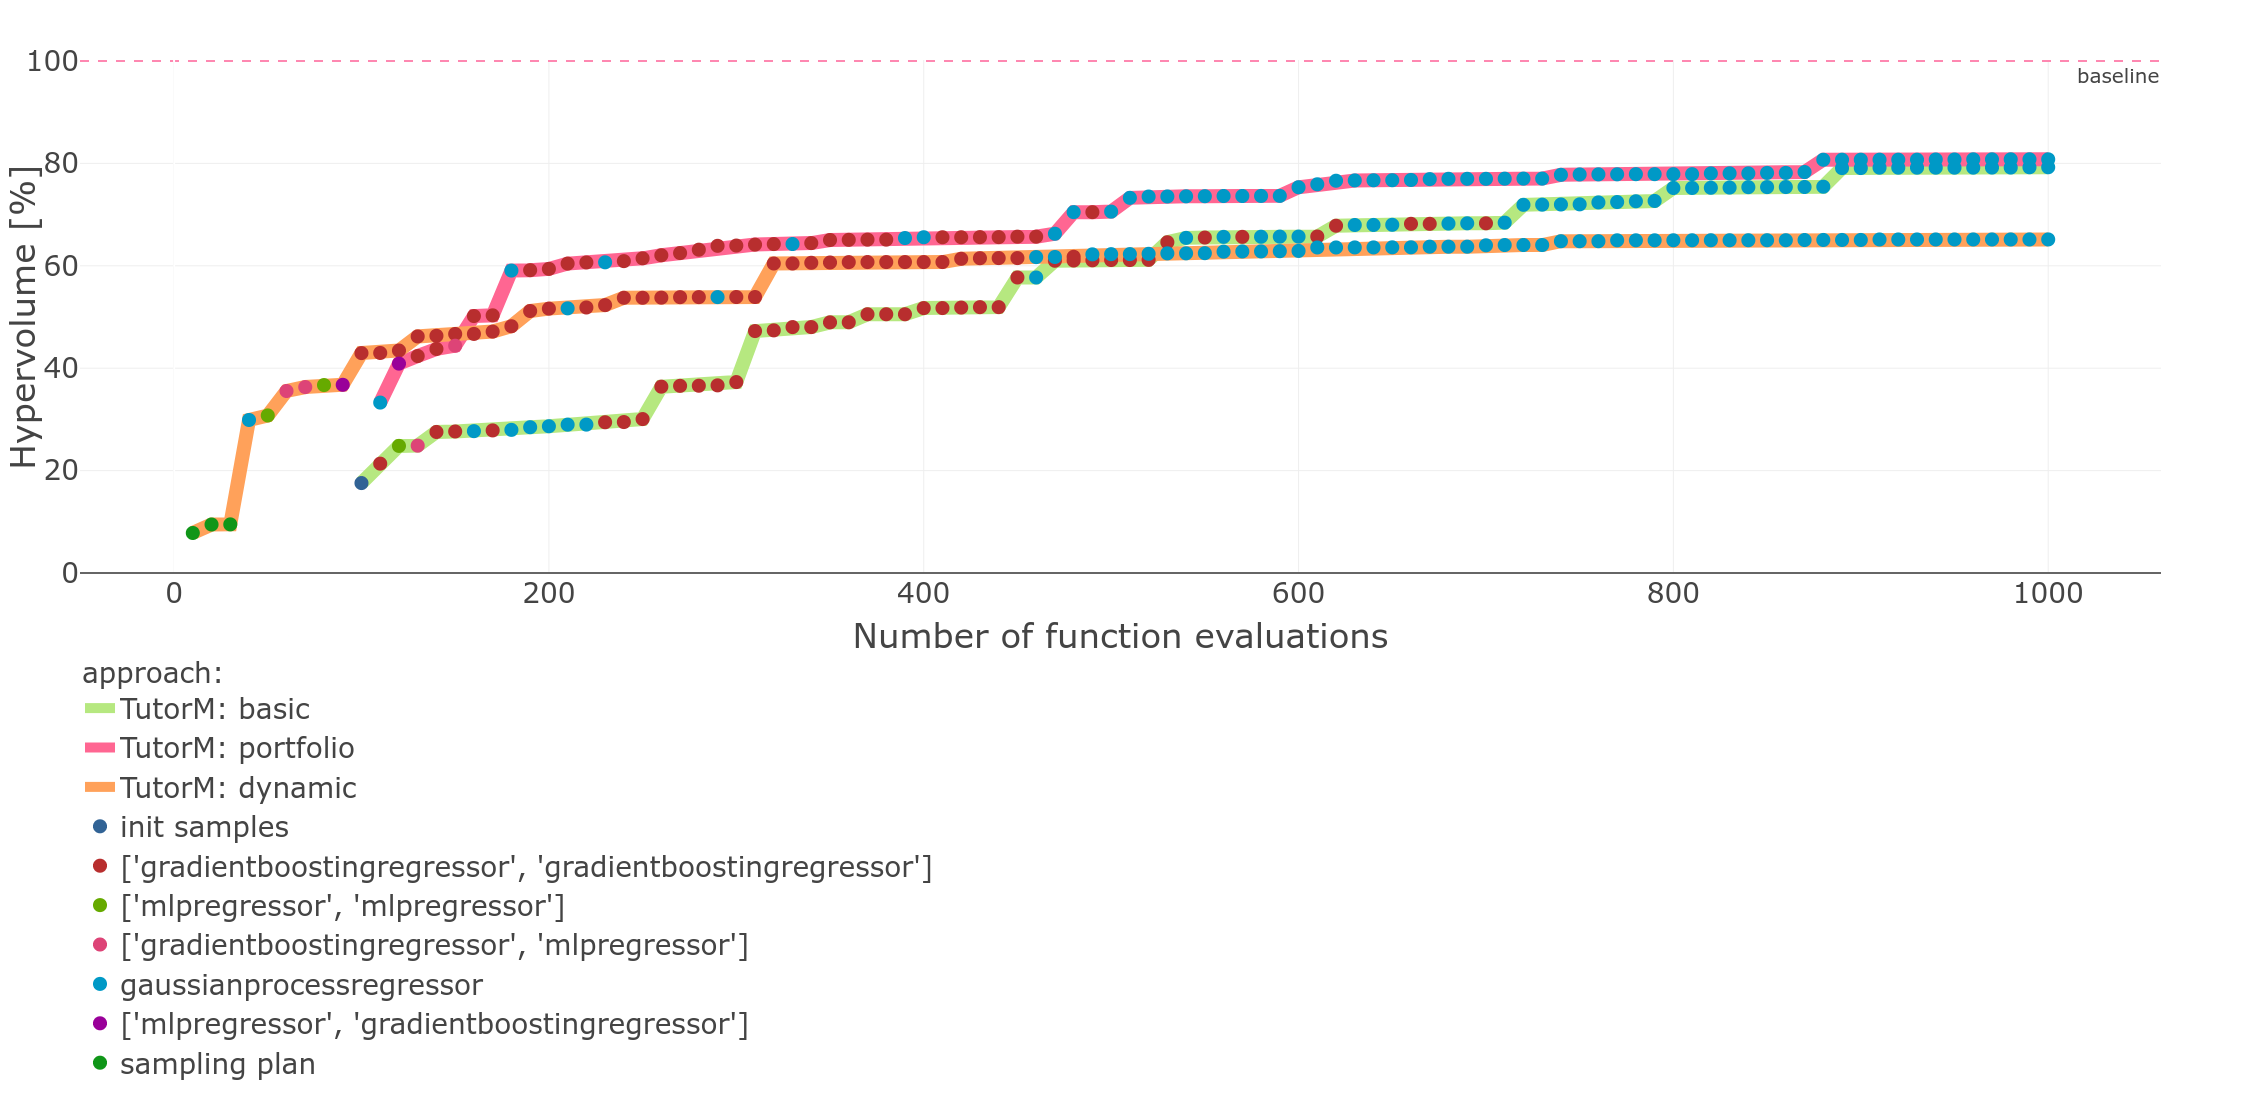

In [20]:
def plot_model_vs_iter(df_tutor):
    
    # --------------------------------------------------------------------------- Tutor     
#     EXP_ORDER = 0
#     df_tutor = [list(df.groupby('tutor_id'))[EXP_ORDER][1] for df in df_tutor]
#     [df.sort_values(by=['i_fevals'], inplace=True) for df in df_tutor]
    
#     def confidence_in_exp(df):
#         df_agg = df.groupby(['i_fevals'])['hypervolume_%'].agg(['mean', 'count', 'std'], axis='columns').reset_index()
#         df_agg.fillna(value=0, inplace=True)
#         approach = df['approach:'].unique()[0]
#         df_agg['approach:'] = approach
#         return df_agg
    
#     df_tutor = [confidence_in_exp(tdf) for tdf in df_tutor]
    
    width = 1600
    height = 1100
    
    
        # --------------------------------------------------------------------------- Tutor     
    EXP_ORDER = 0
    df_tutor = [list(df.groupby('tutor_id'))[EXP_ORDER][1] for df in df_tutor]
    [df.sort_values(by=['i_fevals'], inplace=True) for df in df_tutor]

    df_temp = pd.concat(df_tutor)
    df_temp['model name:'] = df_temp['model name'].astype(str)
        #--- Models on iterations     
    fig1 = px.scatter(df_temp, 
                     x="i_fevals", 
                     y="hypervolume_%", 
                     color="model name:",
                      width=width, height=height,
                     color_discrete_sequence=px.colors.qualitative.G10[::-1],
                      labels={
                          "hypervolume_%": "Hypervolume [%]",  "i_fevals": "Number of function evaluations"
                      },
                     template="presentation")
    fig1.update_traces(marker=dict(size=14),
                  selector=dict(mode='markers'))
    
    # --- TutorM approach     
    fig_main = px.line(pd.concat(df_tutor),
                   x="i_fevals",
                   y="hypervolume_%",
                   width=width, height=height,
                   color_discrete_map={ # replaces default color mapping by value
                       "TutorM: dynamic": "#FFA15A", 
                       "TutorM: portfolio": "#ff6692",
                       "TutorM: basic": "#B6E880"
                   },
                  labels={
                      "hypervolume_%": "Hypervolume [%]",  "i_fevals": "Number of function evaluations"
                  },
                   template="presentation",
                   color="approach:")
    fig_main.update_traces(line=dict(width=14))
    
    
    [fig_main.add_trace(trace) for trace in fig1['data']]
    
    
#     # --- Confidence
#     for tdf in df_tutor:
#         color_discrete_map={
#            "TutorM: dynamic": "rgba(255,161,90,0.3)", 
#            "TutorM: portfolio": "rgba(255, 102, 146,0.3)",
#            "TutorM: basic": "rgba(182,232,128,0.3)"
#         }
#         name = tdf['approach:'].unique()[0]
#         x = tdf['i_fevals'].values.tolist()
#         mean = tdf['mean'].values.tolist()
#         std = tdf['std'].values.tolist()

#         conf = go.Scatter(
#             x=x+x[::-1], # x, then x reversed
#             y=[mean+std for mean, std in zip(mean, std)] + [mean-std for mean, std in zip(mean, std)][::-1], # upper, then lower reversed
#             fill='toself',
#             fillcolor=color_discrete_map[name],
#             line=dict(color='rgba(255,255,255,0)'),
#             hoverinfo="skip",
# #             showlegend=False
#         )
#         fig_main.add_trace(conf)
    
    # --------------------------------------------------------------------------- Others   
    
#     df_others = [gpr_gpr.query('i_fevals>=100'),
#                  solo_gpr.query('i_fevals>=100'),
#                  mlpr_mlpr.query('i_fevals>=100'),
#                  svr_svr.query('i_fevals>=100'),
#                  gbr_gbr.query('i_fevals>=100'),
#                  mapper.query('i_fevals>=100'),
#                  nsga2_df.rename({'group_id': 'solver_id'})]
#     df_others = [confidence_in_exp(tdf) for tdf in df_others]

#     [df.sort_values(by=['i_fevals'], inplace=True) for df in df_others]
    
#     fig3 = px.line(pd.concat(df_others), 
#                  x="i_fevals", 
#                  y="mean", 
#                    width=width, height=height,
#                    color_discrete_sequence=px.colors.qualitative.Pastel,
#                    color_discrete_map={ # replaces default color mapping by value
#                        "GPR": "#7E7DCE",
#                        "[GBR, GBR]": "#B10DA1"
#                    },
#                  color="approach:")
#     fig3.update_traces(line=dict(width=7))
    
    

    
#     # --- Confidence
#     for idx, tdf in enumerate(df_others):
#         color_discrete_map= ['rgba(102, 197, 204, 0.3)',
#              'rgba(246, 207, 113, 0.3)',
#              'rgba(248, 156, 116, 0.3)',
#              'rgba(220, 176, 242, 0.3)',
#              'rgba(135, 197, 95, 0.3)',
#              'rgba(158, 185, 243, 0.3)',
#              'rgba(254, 136, 177, 0.3)',
#              'rgba(201, 219, 116, 0.3)',
#              'rgba(139, 224, 164, 0.3)',
#              'rgba(180, 151, 231, 0.3)',
#              'rgba(179, 179, 179, 0.3)'][::-1]
                
#         name = tdf['approach:'].unique()[0]
#         x = tdf['i_fevals'].values.tolist()
#         mean = tdf['mean'].values.tolist()
#         std = tdf['std'].values.tolist()

#         conf = go.Scatter(
#             x=x+x[::-1], # x, then x reversed
#             y=[mean+std for mean, std in zip(mean, std)] + [mean-std for mean, std in zip(mean, std)][::-1], # upper, then lower reversed
#             fill='toself',
#             fillcolor=color_discrete_map[idx],
#             line=dict(color='rgba(255,255,255,0)'),
#             hoverinfo="skip",
#             showlegend=False
#         )
#         fig_main.add_trace(conf)
    

    # --- update base plot    
#     [fig_main.add_trace(trace) for trace in fig3['data']]
    fig_main.add_hline(y=100, line_dash="dash", line_color="rgb(254, 136, 177)",
              annotation_text="baseline", 
              annotation_position="bottom right",
              annotation_font_size=20)
    fig_main.add_vline(x=0, line_color="rgb(255, 255, 255)")
    fig_main.add_hline(y=0, line_color="rgb(102, 102, 102)")
    
#     fig_main.data = fig_main.data[::-1]
    fig_main.update_layout(
        font=dict(
            size=28,
        ),
        legend=dict(
            yanchor="bottom",
            y=-1,
            xanchor="left",
            x=0
        ))
    fig_main.show()

plot_model_vs_iter([tutor_1_wfg1, tutor_2_wfg1, tutor_dynamic])

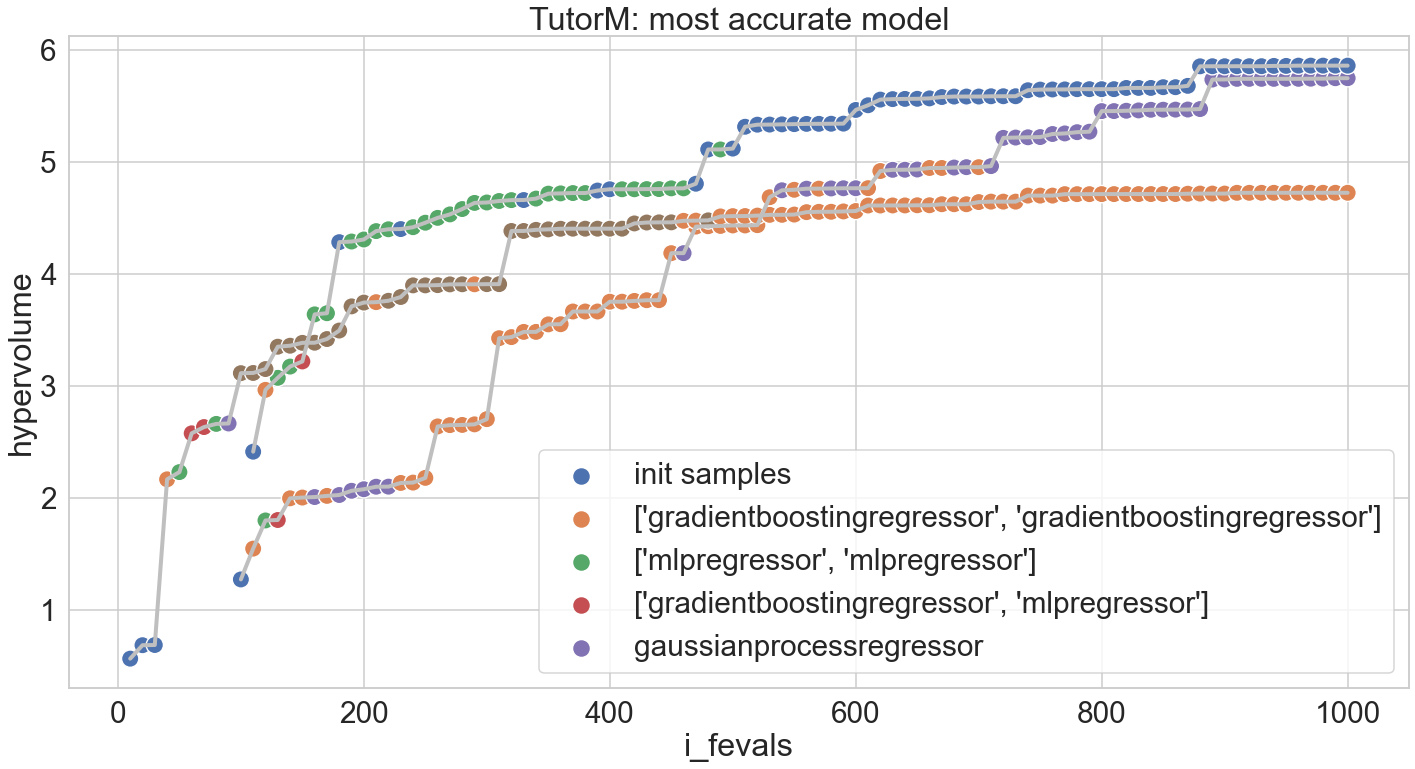

In [21]:
def plot_model_vs_iter2():  
    EXP_ORDER = 0
    sns.set_context("talk",
                font_scale=1.8,
                rc={"lines.linewidth": 4,
                   'lines.markersize': 15}) 
    sns.set_style("whitegrid")
    
    f, axes = plt.subplots(sharex='col', sharey='row', figsize=(24, 12))

    for i, df_temp in enumerate([tutor_1_wfg1, tutor_2_wfg1, tutor_dynamic]):

        
        df_temp = list(df_temp.groupby('tutor_id'))[EXP_ORDER][1]
        df_temp['model name'] = df_temp['model name'].astype(str)

        sns.lineplot(data=df_temp,
                     x="i_fevals", y="hypervolume",
#                      color='#eaedee',
                     ax=axes,
                     color='#bfbfbf',
                    )

        sns.scatterplot(data=df_temp,
                        x="i_fevals", y="hypervolume",
                        s=300,
                        hue="model name",
    #                 marker='X',
                        ax=axes,
                        legend='brief' if i==0 else None,
                        palette="deep").set_title("TutorM: most accurate model")
    
plot_model_vs_iter2()

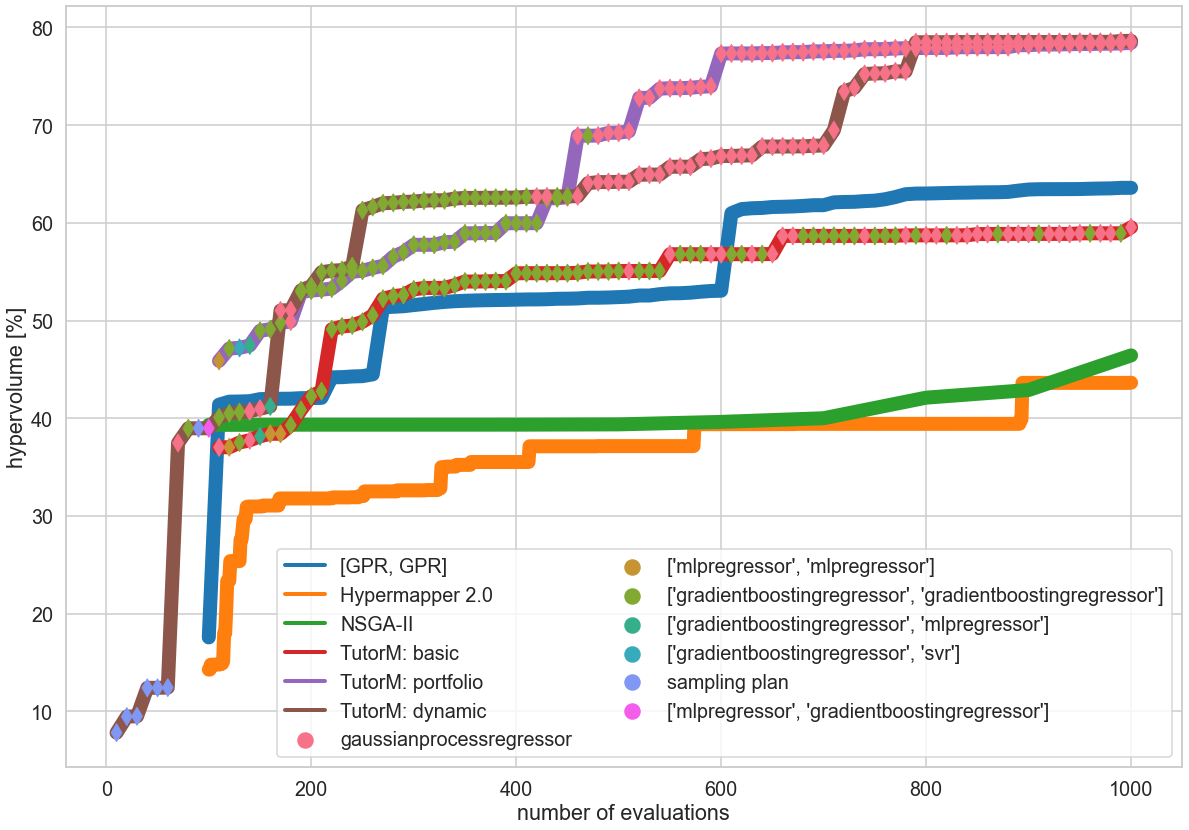

In [110]:
from matplotlib.legend_handler import HandlerLine2D

def plot_hypervolume():
    sns.set_context("talk",
            font_scale=1.2,
            rc={"lines.linewidth": 4,
               'lines.markersize': 15}) 
    sns.set_style("whitegrid")
    
    
    EXP_ORDER = 4

    # ===== Tutor
    tutor_models = []
    for df_temp in [tutor_1_wfg1, tutor_2_wfg1, tutor_dynamic]:
        df_temp = list(df_temp.groupby('tutor_id'))[EXP_ORDER][1]
        df_temp['model name:'] = df_temp['model name'].astype(str)
        tutor_models.append(df_temp)

    f, axes = plt.subplots( figsize=(20,14))
    sns.scatterplot(data=pd.concat(tutor_models),
                    x="i_fevals", y="hypervolume_%",
                    s=160,
                    zorder=9,
                    hue="model name:",
                    edgecolor=None,
                    marker="d",
                    ax=axes,
                    palette="husl")

    # --- Others lines     
    sns.lineplot(x="i_fevals", y="hypervolume_%", markers=True,
                     hue="approach:",
                     palette="tab10", 
                     linewidth=14.0,
                     ax=axes,
                     data=pd.concat([list(t.groupby('solver_id'))[EXP_ORDER][1] for t in [gpr_gpr, 
                                                                                         mapper.query('i_fevals>=100'), 
                                                                                         nsga2_df.rename({'group_id': 'solver_id'}, axis='columns'),
                                                                                         tutor_1_wfg1.rename({'tutor_id': 'solver_id'}, axis='columns'), 
                                                                                         tutor_2_wfg1.rename({'tutor_id': 'solver_id'}, axis='columns'),
                                                                                         tutor_dynamic.rename({'tutor_id': 'solver_id'}, axis='columns')]]))
    
    
    handles, labels  =  axes.get_legend_handles_labels()
               
#     plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2)
    plt.legend(handles, labels, loc='lower right', ncol=2)
    plt.xlabel("number of evaluations")
    plt.ylabel("hypervolume [%]")
    plt.savefig('hypervolume.v1.pdf', bbox_inches = 'tight')
    plt.show()

plot_hypervolume()

In [23]:

def get_hv_for_gbr_and_mlpr(number):
    # === Reference point
    t_ref_point = [[2.94204876, 4.7483657 ],
                  [2.86651553, 4.182231  ],
                  [2.39265076, 4.24209562],
                  [2.66266273, 4.19163483],
                  [2.55394015, 4.24377458],
                  [2.60744901, 4.37163715],
                  [2.46419439, 4.29939536],
                  [2.84698571, 4.61213787],
                  [2.26791158, 4.13958594]][number-1]

    nsga2 = get_data_pkl(f'wfg_nsga/wfg/bench/loop_NSGA2_WFG{number}_32.*.pkl')

    # --- 50k
    y_50k = nsga2.query('i_fevals==50000')['ndf_f'].values
    hv_50k = np.array([pg.hypervolume(y).compute(t_ref_point) for y in y_50k]).mean()
    
    # --- 1k
    y_1k = nsga2.query('i_fevals==1000')['ndf_f'].values
    hv_1k = np.array([pg.hypervolume(y).compute(t_ref_point) for y in y_1k]).mean()
    

    # --- gbr_gbr
    t_gbr_gbr = get_data_pkl(f'solo/gbr_15_04/WFG{number}2_10_paper_solo_loop.*.pkl').query('i_fevals==1000')
    t_gbr_gbr['model name'] = t_gbr_gbr['model name'].astype(str) 
    t_gbr_gbr = t_gbr_gbr[t_gbr_gbr['model name']=="['gradientboostingregressor', 'gradientboostingregressor']"]
    t_gbr_gbr = t_gbr_gbr.apply(lambda row: row_upd_hypervolume(row, t_ref_point), axis=1)
    hv_gbr_gbr = t_gbr_gbr['hypervolume'].mean()
#     print(f"gbr_gbr mean: {hv_gbr_gbr}")

    # --- mlpr_mlpr
    t_mlpr_mlpr = get_data_pkl(f'solo/mlpr_15_04/WFG{number}2_10_paper_solo_loop.*.pkl').query('i_fevals==1000')
    t_mlpr_mlpr['model name'] = t_mlpr_mlpr['model name'].astype(str) 
    t_mlpr_mlpr = t_mlpr_mlpr[t_mlpr_mlpr['model name']=="['mlpregressor', 'mlpregressor']"]
    t_mlpr_mlpr = t_mlpr_mlpr.apply(lambda row: row_upd_hypervolume(row, t_ref_point), axis=1)
    hv_mlpr_mlpr = t_mlpr_mlpr['hypervolume'].mean()
#     print(f"mlpr_mlpr mean: {hv_mlpr_mlpr}")
    
    return {
        "50k": hv_50k,
        "gbr_gbr": hv_gbr_gbr,
        "mlpr_mlpr": hv_mlpr_mlpr,
        "1k": hv_1k
    }

res = pd.DataFrame([get_hv_for_gbr_and_mlpr(n+1) for n in range(9)])
display(res)
res_mean = res.mean()
display(res_mean)

print(f"mlpr_mlpr %: {99.725*res_mean['mlpr_mlpr']/res_mean['50k']}")
print(f"gbr_gbr %: {99.725*res_mean['gbr_gbr']/res_mean['50k']}")
print(f"nsga2 1k %: {99.725*res_mean['1k']/res_mean['50k']}")

50k   gbr_gbr  mlpr_mlpr        1k
0  6.547787  4.012542   3.584945  2.312393
1  8.406944  8.190279   8.313269  8.155730
2  6.072821  5.539752   6.111427  5.876748
3  4.834760  4.818927   4.777157  4.716672
4  4.178115  4.190424   4.174890  4.034472
5  5.055172  5.058939   5.102592  4.778418
6  4.270600  4.274993   4.245230  4.134614
7  6.233940  6.053213   6.558655  5.241453
8  3.056253  2.936577   2.982566  2.969925

50k          5.406266
gbr_gbr      5.008405
mlpr_mlpr    5.094526
1k           4.691158
dtype: float64

mlpr_mlpr %: 93.97458562224884
gbr_gbr %: 92.38599146475318
nsga2 1k %: 86.533994698545
